# Analyzing Chile's Earthquake Data

We want to __import, clean and do statistical analysis__ of Chile's earthquake data from [Centro Sismológico Nacional](https://www.csn.uchile.cl) (CSN). There are two main datasets: Chile's biggest earthquakes (magnitude Ms greater or equal to 7) and Chile's significant earthquake events (with magnitude Ms greater or equal to 3).

## Methods

### Data Wrangling

Our major technical challenge here is to scrape HTML data from the CSN website. There are many ways to do this, but we will use the library `BeautifulSoup4` to achieve this. We will then use different ways to transform HTML data into pandas tables. In particular, section 2 downloads tables from multiple HTML sites and joins them into one dataframe.  

### Data Visualization

We shall use `matplotlib` and `seaborn` for graphics and `folium` ([site](https://python-visualization.github.io/folium/index.html)) to show the geolocation of major earthquakes.

## 1. Chile's Major Earthquakes

### 1.1 Importing HTML data

Let us import all necessary libraries first.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Then, our first task is to import the HTML data using `BeautifulSoup4`.

In [2]:
# URL to be imported
url = 'https://www.csn.uchile.cl/sismologia/grandes-terremotos-en-chile/'
# Open a URL request
r = requests.get(url)
# Get HTML text
html_doc = r.text
# Create a BeautifulSoup object to extract HTML data using Tags
soup = BeautifulSoup(html_doc)

There is only one HTML table in this URL and we want to transform it into a DataFrame. In HTML, `tr` stands for “table row”, `th` stands for “table header” and `td` stands for “table data”, which is where the data is stored as text. The solution presented here is from [this blog post](https://towardsdatascience.com/a-guide-to-scraping-html-tables-with-pandas-and-beautifulsoup-7fc24c331cf7).

In [3]:
# Implement a loop to fill table's rows
rows = []
# Not all tables have a tbody tag, but this one does. Otherwise, use table attribute.
for child in soup.tbody.children:
    row = []
    for td in child:
        try:
            # Convert new lines to empty space
            row.append(td.text.replace('\n', '')) 
        except:
            continue
    if len(row) > 0:
        rows.append(row)
        
df = pd.DataFrame(rows[1:], columns=rows[0])

Let us take a look at our table.

In [4]:
df.head()

,Fecha local,Hora local,Latitud,Longitud,Magnitud Ms,Magnitud Mw,Profundidad [km],Efecto
0,08/02/1570,9:00,-36.800,-73.000,8.3,-,-,TD
1,17/03/1575,10:00,-33.400,-70.600,7.3,-,-,-
2,16/12/1575,14:30,-39.800,-73.200,8.5,-,-,TD
3,24/11/1604,12:30,-18.500,-70.400,8.5,-,30,TD
4,16/09/1615,23:30,-18.500,-70.350,8.8,-,-,TM


In [5]:
df.tail()

,Fecha local,Hora local,Latitud,Longitud,Magnitud Ms,Magnitud Mw,Profundidad [km],Efecto
109,27/02/2010,03:34,-36.290,-73.239,-,8.8,30,TD
110,01/04/2014,20:46,-19.572,-70.908,-,8.2,38.9,T
111,16/09/2015,19:54,-31.553,-71.864,-,8.4,11.1,TD
112,25/12/2016,11:22,-43.517,-74.391,-,7.6,30,T
113,01/09/2020,00:09,-27.969,-71.241,-,7.0,31,-


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Fecha local       114 non-null    object
 1   Hora local        114 non-null    object
 2   Latitud           114 non-null    object
 3   Longitud          114 non-null    object
 4   Magnitud Ms       114 non-null    object
 5   Magnitud Mw       114 non-null    object
 6   Profundidad [km]  114 non-null    object
 7   Efecto            114 non-null    object
dtypes: object(8)
memory usage: 7.2+ KB


The earthquake table contains events of magnitude Ms (from superficial waves) or Mw (momentum magnitude) larger or equal than 7.0 ordered by date and time. We also have the latitude and longitude of the epicenter, depth in km and the effect. Surprisingly, the records span 450 years of data! The questions we want to address in this notebook are

* What are the statistical properties of the data?
* How are the events distributed in space and time?
* What's the frequency of events as a function of their magnitude?

### 1.2 Cleaning the data

We would like to convert the earthquake's dates to `datetime`, but the date interval is out of bound. The maximum interval allowed by `datetime` is 584 years, as can be seen below. However, the first earthquake in the list is from the year 1570! Therefore, we shall work with dates more explictly.

In [7]:
pd.Timestamp.min, pd.Timestamp.max

(Timestamp('1677-09-21 00:12:43.145224193'),
 Timestamp('2262-04-11 23:47:16.854775807'))

We first extract the day, month and year explicitly.

In [8]:
# Extracting day, month and year 
date = df["Fecha local"].values
day, month, year = [[my_str.split("/")[i] for my_str in date] for i in range(3)]
df["year"] = year
df["month"]= month
df["day"] = day

Let us rename the columns to English for convenience and convert empty values `-` to NaN and Magnitud values with `,` to `.` decimal sign.

In [9]:
df_clean = df.replace({",":".", "-$": np.nan}, regex=True).apply(pd.to_numeric, errors='ignore')
cols = ['date', 'time', 'latitude', 'longitude', 'mag_ms', 'mag_mw', 'depth_km', 'effect', 'year', 'month', 'day'] 
df_clean.columns = cols
df_clean.head()

,date,time,latitude,longitude,mag_ms,mag_mw,depth_km,effect,year,month,day
0,08/02/1570,9:00,-36.8,-73.00,8.3,NaN,NaN,TD,1570,2,8
1,17/03/1575,10:00,-33.4,-70.60,7.3,NaN,NaN,NaN,1575,3,17
2,16/12/1575,14:30,-39.8,-73.20,8.5,NaN,NaN,TD,1575,12,16
3,24/11/1604,12:30,-18.5,-70.40,8.5,NaN,30.0,TD,1604,11,24
4,16/09/1615,23:30,-18.5,-70.35,8.8,NaN,NaN,TM,1615,9,16


In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       114 non-null    object 
 1   time       111 non-null    object 
 2   latitude   114 non-null    float64
 3   longitude  114 non-null    float64
 4   mag_ms     108 non-null    float64
 5   mag_mw     14 non-null     float64
 6   depth_km   62 non-null     float64
 7   effect     34 non-null     object 
 8   year       114 non-null    int64  
 9   month      114 non-null    int64  
 10  day        114 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.9+ KB


We see that most events have a Ms record, but only 14 Mw records. Mw records are the current Magnitude standard for large earthquakes with M > 4 (https://en.wikipedia.org/wiki/Moment_magnitude_scale), considered to be more reliable than Ms. However, we will mostly analyze the Ms records, as we have a much larger number of events.

### 1.3 Analyzing the Data

#### Distribution of Major Earthquakes in Time

Let us first check the distribution of major earthquakes per year. We rename the dataframe to simplify the analysis.

In [11]:
df = df_clean.copy()

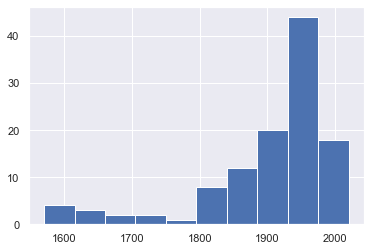

In [12]:
nbins = int(np.sqrt(len(df)))
df['year'].hist(bins=nbins)
plt.show()

In this plot, we see that the majority of events was registered in the 1900s. This is expected, as seismographs have become more widespread in the 20th century. Therefore, in the following, __we will only analyze events after the year 1900__. However, there is a decay on the number of events closer to the year 2000. Let us check the events in the past century more closely to see what is happening.

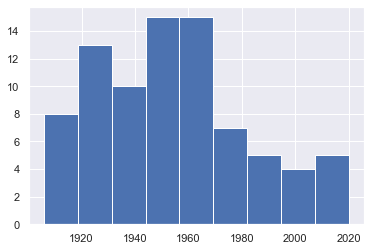

In [13]:
df1900 = df[df['year'] >= 1900]
nbins = int(np.sqrt(len(df1900)))
df1900['year'].hist(bins=nbins)
plt.show()

We see an important drop in the number of major events after 1970. It is unclear why that is the case and it would require a more refined analysis of earthquake phenomenology to understand what is going on. According to this [paper](https://academic.oup.com/gji/article/143/2/438/701588?login=true), the negative binomial distribution is a good fit for the number of earthquakes per year. We shall leave a more refined analysis of this problem for the future.

What is the average number of earthquakes per year?

In [14]:
avg_events_year = df1900['year'].value_counts().mean()
avg_events_year

1.4385964912280702

We have a large number of apparently rare events, as there are less than 2 events per year and some years did not have large events. This suggests that the number of earthquakes might be Poisson distributed. Let us check this assumption.

First, we create a table with all years from 1906 to 2020.

In [15]:
years = pd.DataFrame({'year' : range(min(df1900['year']), max(df1900['year'])+1)})
years.head()

,year
0,1906
1,1907
2,1908
3,1909
4,1910


Then we count the number of events per year and merge this table with the table with all the years.

In [16]:
event_count = df1900.value_counts('year').sort_index()
df_count = pd.DataFrame({'year': event_count.index, 'events' : event_count.values})
events_per_year = years.merge(df_count, on='year', how='left').replace(np.nan,0).astype(int).set_index('year')
events_per_year.head(10)

,events
year,
1906,1
1907,0
1908,0
1909,1
1910,1
1911,1
1912,0
1913,0
1914,1


We can now see the proportion of years between 1906 and 2020 that did not have major events:

In [17]:
(100*events_per_year[events_per_year.events == 0].count()/len(events_per_year))[0]

50.43478260869565

That is approximately 50%, suggesting that major events happen randomly across the years. Now let us check the observed distribution of the number of events. 

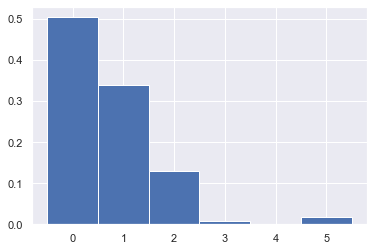

In [18]:
bins = np.arange(0, max(events_per_year.events) + 1.5) - 0.5
plt.hist(events_per_year, density=True, bins=bins)
plt.show()

We want to compare this with a Poisson distribution with an average of 1.48 events per year. 

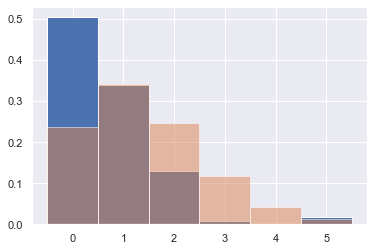

In [19]:
poisson = np.random.poisson(avg_events_year, 100000)

plt.hist(events_per_year, density=True, bins=bins)
plt.hist(poisson, density=True, bins=bins, alpha=0.5)

plt.show()

We see some similarity in the decay, but they are not quite the same. Let us check the _negative binomial distribution_ assuming that we have 1 event per year with a 50% probability.

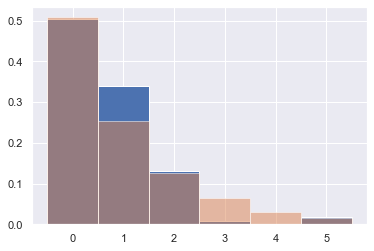

In [20]:
plt.hist(events_per_year, density=True, bins=bins)
neg_binomial = np.random.negative_binomial(1, 0.5, 100000)
plt.hist(neg_binomial, density=True, range=(0,5), alpha=0.5,bins=bins)
plt.show()

That is much more like it! We can see the match in more detail with an __empirical cumulative distribution__ (ECDF), using the function defined below.

In [21]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

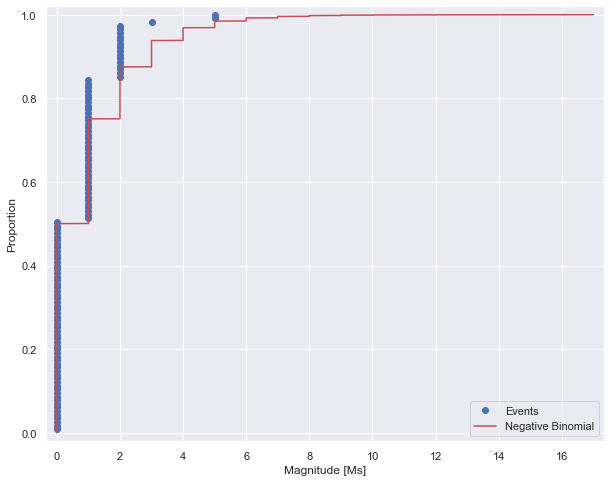

In [67]:
x, y = ecdf(events_per_year['events'])
xnb, ynb = ecdf(neg_binomial)

plt.figure(figsize=(10,8))
plt.plot(x, y, 'bo', label='Events')
plt.plot(xnb, ynb, 'r-', label='Negative Binomial')
plt.xlabel('Magnitude [Ms]')
plt.ylabel('Proportion')
# sns.ecdfplot(events_per_year.events)
# sns.ecdfplot(neg_binomial)
plt.legend()
plt.margins(0.02) # Keeps data off plot edges
plt.show()

The match is quite good, but still not perfect. However, it works well as a first approximation.

Now let us check the distribution of events per month of the year.

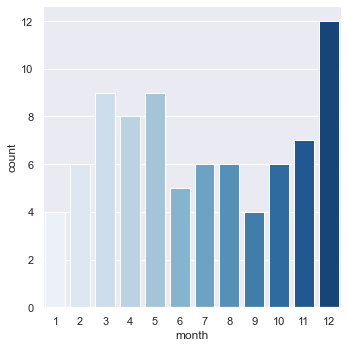

In [23]:
sns.catplot(x='month', data=df1900.sort_values('month'), kind='count', palette='Blues')
plt.show()

There is a significant larger amount of big earthquakes in December. How do we know if this is statistically significant? We have to do a __hypothesis test__. Let us assume that earthquakes happen at random across the months of the year. What is the likelihood of getting the observed values? To test this, we shall create a large number of random __bootstrap samples__ from our month data and analyze the distribution of events.

#### Magnitude [Ms] Distributions in Space and Time

Let us compute the _empirical cumulative distribution_ (ECDF) of the Ms magnitude.

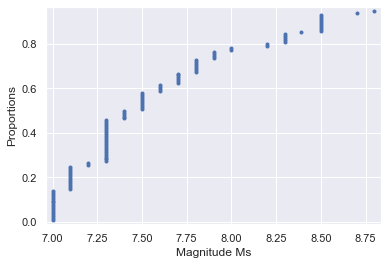

In [50]:
x, y = ecdf(df['mag_ms'])
plt.plot(x, y, '.')
plt.xlabel('Magnitude Ms')
plt.ylabel('Proportions')
plt.margins(0.02) # Keeps data off plot edges
plt.show()

From this we see that around 60% of major earthquakes had a magnitude Ms lower or equal than 7.5 and only 20% of the events had a magnitude higher than 8.25. We can see this in more detail with a histogram:

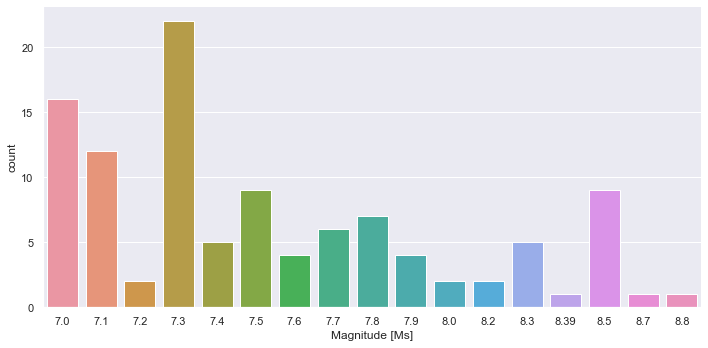

In [55]:
magnitud_ms = df[~df['mag_ms'].isna()].sort_values('mag_ms')

g1 = sns.catplot(x='mag_ms',data=magnitud_ms, kind='count', aspect=2)
g1.set(xlabel='Magnitude [Ms]')

plt.show()

We can also check the Magnitude distribution per month with a boxplot.

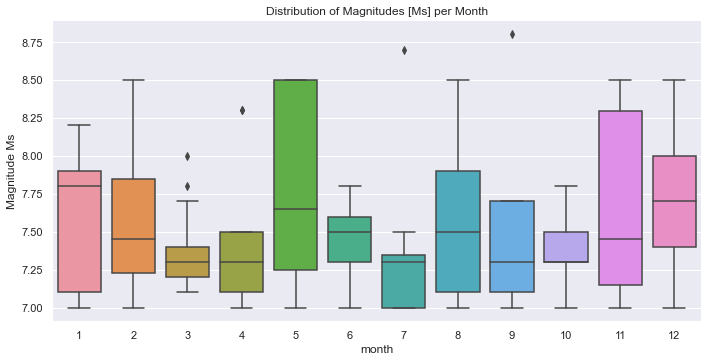

In [56]:
g = sns.catplot(x='month', y='mag_ms', data=magnitud_ms, kind='box', aspect=2)
g.set(ylabel='Magnitude Ms', title='Distribution of Magnitudes [Ms] per Month')
plt.show()

There is a large variability with respect to different months, but this is might be due to the small number of events. To analyze this distribution

Do we see any trend in the event's magnitudes in time? We can test this by a linear regression plot.

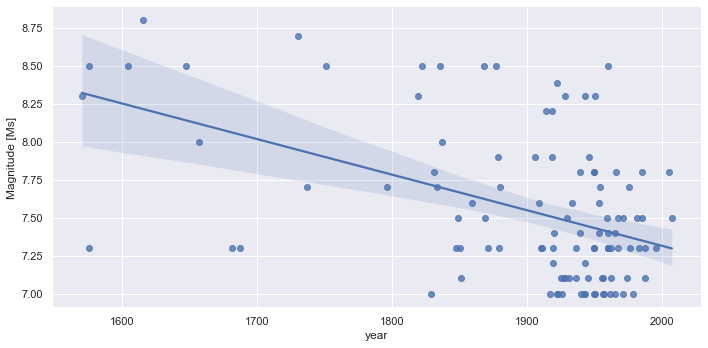

In [34]:
#magnitud_ms = df_clean[(~df_clean['mag_ms'].isna()) & (df_clean['year'] > 1900)].sort_values('mag_ms')

g1 = sns.lmplot(y='mag_ms', x='year', data=magnitud_ms, aspect=2)
g1.set(ylabel='Magnitude [Ms]')

plt.show()

There is no clear trend, although there appears to be a slight decline in the average magnitude. Let us check the __Pearson correlation coefficient__ of magnitude and year.

In [19]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [35]:
pearson_r(magnitud_ms['year'].values,magnitud_ms['mag_ms'].values)

-0.4779333877528952

We can also take a look at the spatial distribution of magnitudes with a simple scatter plot. 

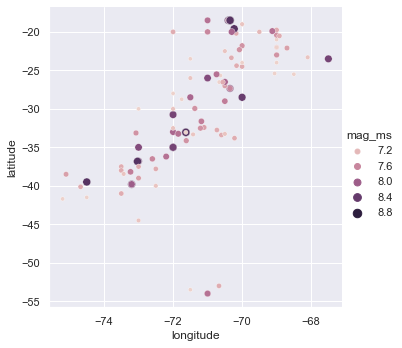

In [106]:
g2 = sns.relplot(x='longitude', y='latitude', data=df, kind='scatter', size='mag_ms', hue='mag_ms')

plt.show()

In order to look like the usual Mercator world map projection, we would need to rescale the axis and do an overlay with Chile's territory. Thankfully, we can use the library `folium` to create a map with the distribution of major earthquakes in Chile. Let us plot all major events since 1950 that the magnitude Ms has been recorded.

In [108]:
import folium

events_locations = df[(df['year'] > 1950) & ~(df['mag_ms'].isna())][['latitude','longitude','mag_ms','year']]

map = folium.Map(location=[events_locations.latitude.mean(), events_locations.longitude.mean()],\
                 zoom_start=4, control_scale=True, tiles="Stamen Terrain")


for index, location_info in events_locations.iterrows():
    popup_text = 'Year: '+str(int(location_info['year'])) +'\nMagnitude Ms: '+str(location_info['mag_ms'])
    folium.Marker([location_info["latitude"], location_info["longitude"]],\
                 popup=popup_text).add_to(map)
    
map

Finally, just out of curiosity, let us see all the major events in 1960, the year of the biggest recorded earthquake in history, which nearly destroyed the city of Valdivia in the south of Chile.

In [60]:
df_clean[df_clean['year'] == 1960]

,date,time,latitude,longitude,mag_ms,mag_mw,depth_km,effect,year,month,day
80,21/05/1960,6:02,-37.5,-73.5,7.3,NaN,NaN,NaN,1960,5,21
81,22/05/1960,6:32,-37.5,-73.0,7.3,NaN,NaN,NaN,1960,5,22
82,22/05/1960,15:11,-39.5,-74.5,8.5,9.5,NaN,TD,1960,5,22
83,19/06/1960,22:01,-38.0,-73.5,7.3,NaN,NaN,NaN,1960,6,19
84,01/11/1960,4:45,-38.5,-75.1,7.4,NaN,55.0,NaN,1960,11,1


In the span of two days, there were 3 major events with magnitude Ms higher than 7.0! The major one had a magnitude of 8.5 and a historical reconstruction of the event estimates a magnitude Mw of 9.5, the highest ever in the recorded history.

## 2. Chile's Significant Earthquake Events

### 2.1  Importing and Cleaning Data

First use the packages `requests` and `bs4` to import the webpage with earthquake data. As we gonna see below, the table of this page continues in multiple pages. We need to extract the number of pages to make a full extraction of all available events.

In [135]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# URL to be imported
url = 'http://evtdb.csn.uchile.cl'
# Open a URL request 
r = requests.get(url)
# Get HTML text
html_doc = r.text
# Create a BeautifulSoup object to extract HTML data using Tags
soup = BeautifulSoup(html_doc)

Those are the BS4 elements of the HTML page:

In [126]:
[type(item) for item in list(soup.children)]

[bs4.element.Doctype, bs4.element.Tag]

In [217]:
numbers = []
for item in soup.find_all('li'):
    if str(item.string).find('Página') != -1:
        for word in str(item.string).split():
            if word.isdigit():
                numbers.append(int(word))
                
print(numbers[-1])

136


This method works, but there is a more direct way, in which we do not even need to extract the page number! We just need to

In [226]:
df = pd.DataFrame()
page = 1
while requests.get(url+"/?page="+str(page)).status_code == 200:
    r = requests.get(url+"/?page="+str(page))
    soup = BeautifulSoup(r.text)
    df = df.append(pd.read_html(str(soup.find_all(class_="paleblue sortable")))[0], ignore_index=True)
    page += 1
else:
    print("Failed in page " + str(page) + "due to HTTP code" + str(requests.get(url+"/?page="+str(page)).status_code))

Failed in page137due to500


In [240]:
df.head()

,Fecha (UTC),Latitud [º],Longitud [º],Profundidad [km],Magnitud [*]
0,2021-11-24 23:14:32,-20.52,-69.18,98,4.9
1,2021-11-18 14:10:05,-20.93,-68.87,127,4.5
2,2021-11-13 00:16:58,-22.14,-70.44,30,3.6
3,2021-11-04 04:18:22,-30.31,-71.22,52,5.2
4,2021-11-03 03:17:47,-32.66,-70.11,113,5.8


In [243]:
df['Fecha (UTC)'] = df['Fecha (UTC)'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702 entries, 0 to 2701
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Fecha (UTC)       2702 non-null   datetime64[ns]
 1   Latitud [º]       2702 non-null   float64       
 2   Longitud [º]      2702 non-null   float64       
 3   Profundidad [km]  2702 non-null   int64         
 4   Magnitud [*]      2702 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 105.7 KB


In [244]:
df.isna().sum()

Fecha (UTC)         0
Latitud [º]         0
Longitud [º]        0
Profundidad [km]    0
Magnitud [*]        0
dtype: int64

In [245]:
cols = ['date_utc', 'latitude_deg', 'longitude_deg', 'depth_km', 'magnitude'] 
df.columns = cols
df.head()

,date_utc,latitude_deg,longitude_deg,depth_km,magnitude
0,2021-11-24 23:14:32,-20.52,-69.18,98,4.9
1,2021-11-18 14:10:05,-20.93,-68.87,127,4.5
2,2021-11-13 00:16:58,-22.14,-70.44,30,3.6
3,2021-11-04 04:18:22,-30.31,-71.22,52,5.2
4,2021-11-03 03:17:47,-32.66,-70.11,113,5.8


###  Exploratory Data Analysis

Our table contains sismic events ordered by datetime, location, depth and magnitude. The questions we want to address in this notebook are

* How are the events distributed in space and time?
* What's the frequency of events as a function of their magnitude?

In [269]:
df.describe()
plt.show()

,latitude_deg,longitude_deg,depth_km,magnitude
count,2702.000000,2702.000000,2702.000000,2702.000000
mean,-27.506077,-70.825862,60.570688,4.547668
std,5.879959,1.283901,38.800012,0.660332
min,-62.350000,-74.820000,2.000000,2.300000
25%,-31.590000,-71.590000,35.000000,4.100000
50%,-29.590000,-71.160000,48.000000,4.500000
75%,-21.110000,-70.060000,84.000000,4.900000
max,-11.070000,-58.390000,624.000000,8.400000


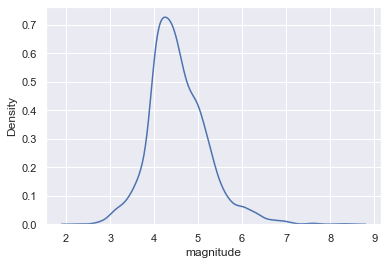

In [260]:
sns.kdeplot(x='magnitude', data=df)
plt.show()

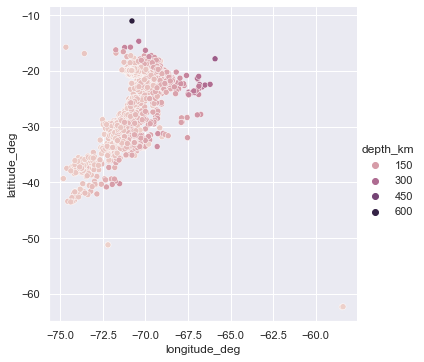

In [268]:
sns.relplot(x='longitude_deg', y= 'latitude_deg', hue='depth_km', data=df)
plt.show()

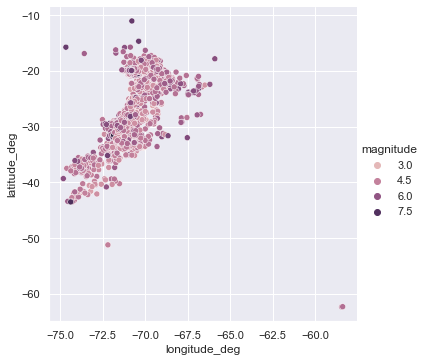

In [270]:
sns.relplot(x='longitude_deg', y= 'latitude_deg', hue='magnitude', data=df)
plt.show()

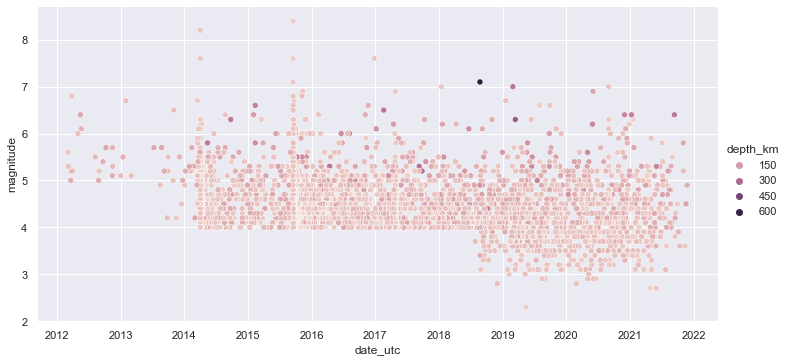

In [287]:
sns.relplot(x='date_utc', y='magnitude', hue='depth_km', data=df, kind='scatter', aspect=2)
plt.show()

## Next Steps

* Check the Gutenber-Ritcher (Log(number of events per century) vs. magnitude) and Utsu-Omori laws (distribution of replicas with time).
* Can we find correlations between these events and other geophysical data like volcano eruptions?
* Explore other datasets with a larger quantity of events.
* Try to predict earthquakes from seismograph data.